## Imporiting Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
data_dir = 'C:\\Users\\AJAY KRISHNA\\OneDrive\\Documents\\Projects\\GTSRB - German Traffic Sign Recognition Benchmark'
train_path = 'C:\\Users\\AJAY KRISHNA\\OneDrive\\Documents\\Projects\\GTSRB - German Traffic Sign Recognition Benchmark\\Train'
test_path = 'C:\\Users\\AJAY KRISHNA\\OneDrive\\Documents\\Projects\\GTSRB - German Traffic Sign Recognition Benchmark\\Test'

IMG_HEIGHT = 75
IMG_WIDTH = 75
channels = 3
IMG_SIZE = [75,75]

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
classes = { 0:'Speed limit (20km/h)',1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 
            9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
            12:'Priority road', 13:'Yield', 14:'Stop', 
            15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 17:'No entry', 
            18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right', 
            21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 
            24:'Road narrows on the right', 25:'Road work', 26:'Traffic signals', 
            27:'Pedestrians', 28:'Children crossing', 29:'Bicycles crossing', 
            30:'Beware of ice/snow',31:'Wild animals crossing', 32:'End speed + passing limits', 
            33:'Turn right ahead', 34:'Turn left ahead', 35:'Ahead only', 
            36:'Go straight or right', 37:'Go straight or left', 38:'Keep right', 
            39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing the Dataset

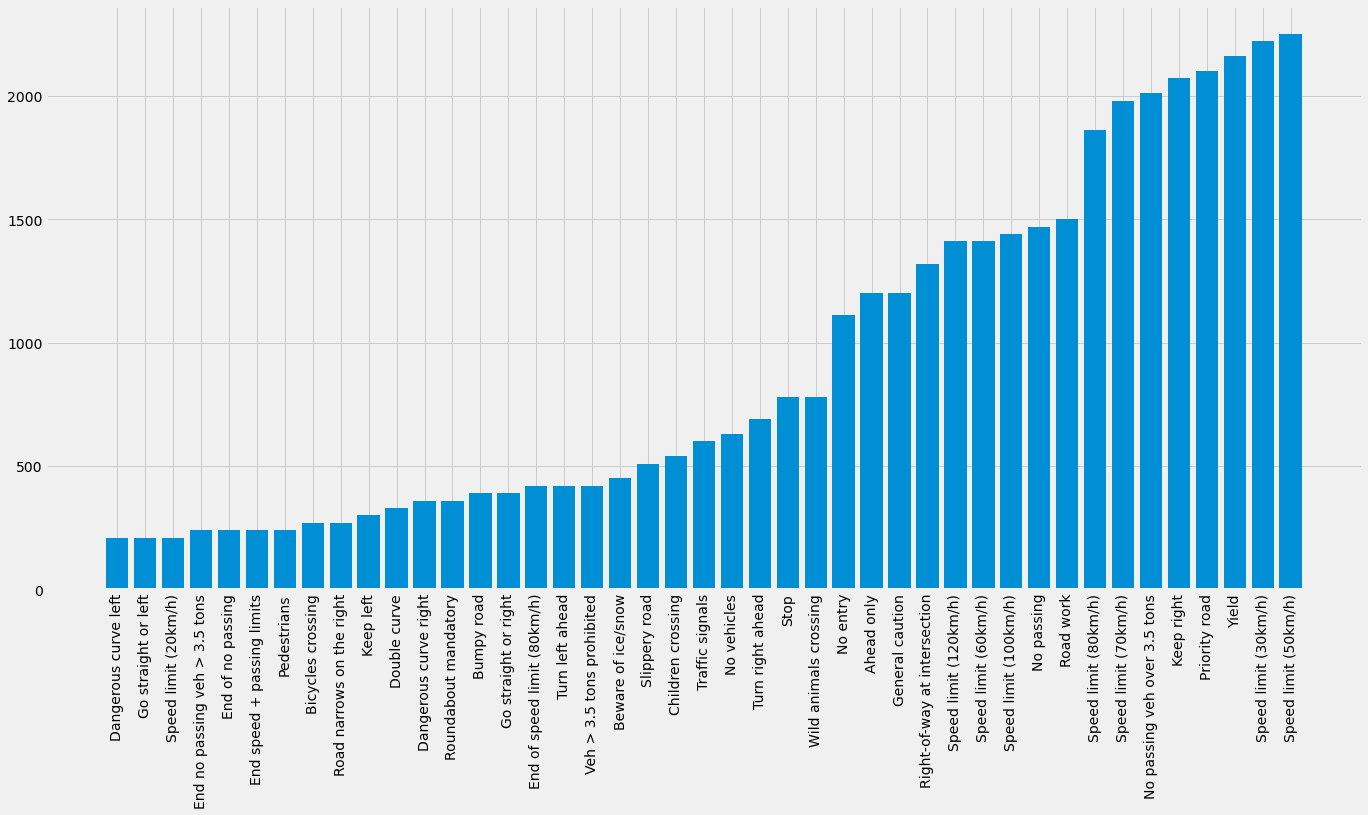

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\AJAY KRISHNA\AppData\Local\Temp\ipykernel_6456\697985605.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


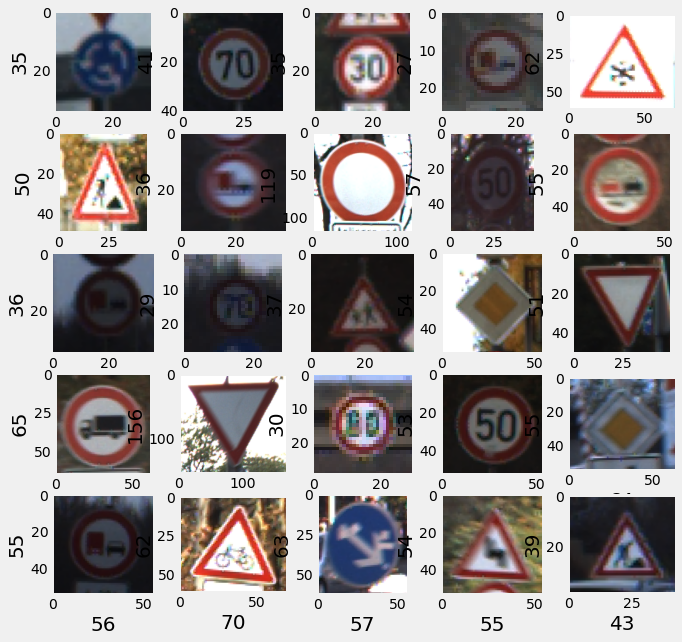

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values


plt.figure(figsize=(10,10))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [8]:
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

a = []
for i in range(NUM_CATEGORIES):
    # Get the Image Resolutions
    imgs = [img.name for img in Path(train_path +'\\'+str(i)).iterdir() if img.suffix == ".png"]
    img_meta = {}
    imgs.sort()
    # print(imgs)

    for f in imgs: img_meta[str(f)] = imagesize.get(train_path +'\\'+str(i)+'/'+f)
    # print(img_meta)
    
    img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
    img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
    img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

    a.append(img_meta_df)

result = pd.concat(a)
print(result)

                  FileName      Size  Width  Height  Aspect Ratio
0    00000_00000_00000.png  (29, 30)     29      30          0.97
1    00000_00000_00001.png  (30, 30)     30      30          1.00
2    00000_00000_00002.png  (30, 30)     30      30          1.00
3    00000_00000_00003.png  (31, 31)     31      31          1.00
4    00000_00000_00004.png  (30, 32)     30      32          0.94
..                     ...       ...    ...     ...           ...
235  00042_00007_00025.png  (52, 56)     52      56          0.93
236  00042_00007_00026.png  (56, 58)     56      58          0.97
237  00042_00007_00027.png  (58, 62)     58      62          0.94
238  00042_00007_00028.png  (63, 69)     63      69          0.91
239  00042_00007_00029.png  (68, 69)     68      69          0.99

[39209 rows x 5 columns]


Text(0, 0.5, 'Height')

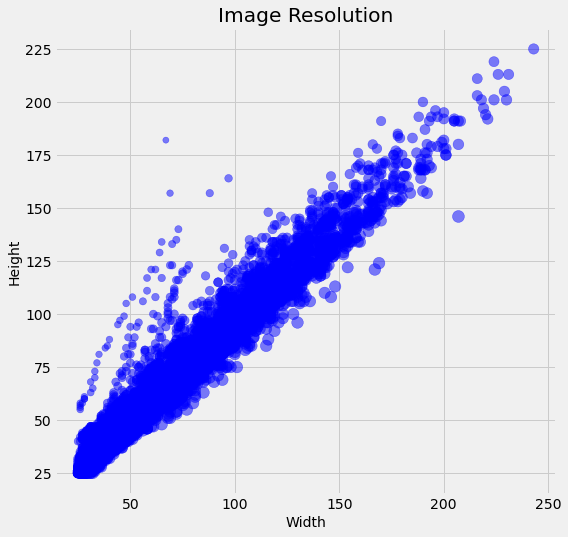

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
points = ax.scatter(result.Width, result.Height, color='blue', alpha=0.5, s=result["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

## Collecting the Training Data

In [16]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)
            
    # Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 75, 75, 3) (39209,)


## Splitting the data into train and validation set

In [17]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 75, 75, 3)
X_valid.shape (11763, 75, 75, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [14]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [15]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [16]:
lr = 0.001
epochs = 10

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


C:\Users\AJAY KRISHNA\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Augmenting the data and training the model

In [17]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
858/858 [==============================] - 342s 395ms/step - loss: 1.3393 - accuracy: 0.6420 - val_loss: 0.1939 - val_accuracy: 0.9457
Epoch 2/10
858/858 [==============================] - 341s 397ms/step - loss: 0.2040 - accuracy: 0.9400 - val_loss: 0.0482 - val_accuracy: 0.9860
Epoch 3/10
858/858 [==============================] - 340s 396ms/step - loss: 0.1059 - accuracy: 0.9687 - val_loss: 0.0198 - val_accuracy: 0.9943
Epoch 4/10
858/858 [==============================] - 341s 397ms/step - loss: 0.0728 - accuracy: 0.9790 - val_loss: 0.0150 - val_accuracy: 0.9966
Epoch 5/10
858/858 [==============================] - 341s 398ms/step - loss: 0.0589 - accuracy: 0.9821 - val_loss: 0.0499 - val_accuracy: 0.9853
Epoch 6/10
858/858 [==============================] - 341s 398ms/step - loss: 0.0452 - accuracy: 0.9870 - val_loss: 0.0226 - val_accuracy: 0.9923
Epoch 7/10
858/858 [==============================] - 339s 395ms/step - loss: 0.0390 - accuracy: 0.9879 - val_loss: 0.0077 -

## Evaluating the model

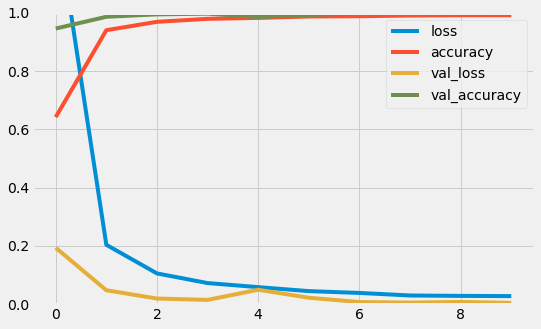

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

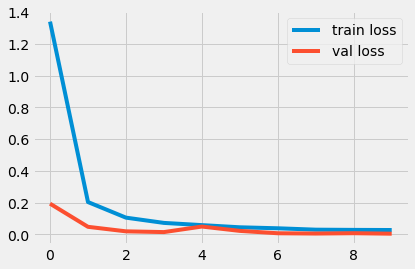

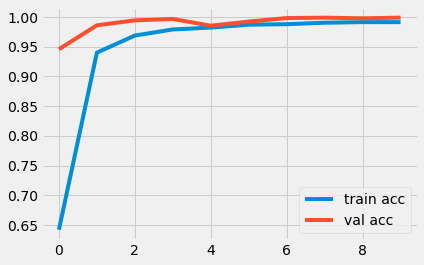

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Loading the test data and running the predictions

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)